# IDAO bootcamp deep leanning

### Plans for this notebook:

1. Quick introduction in deep learning
2. **Pytorch** basics
3. Some details about learning pipeline
4. Build and apply simple fully connected nural network
5. Introduction to conv nets
6. Build and apply simple convolutional nural network



##### This notebook is strongly based on materials from: https://github.com/hse-ds/iad-deep-learning

# 1. Quick introduction in deep learning [mini-presentation](https://docs.google.com/presentation/d/1cc9n11O6I_18bunhgw8qfuJ7kp2ITD9hfIZsp_8lpJA/edit?usp=sharing)

# 2. Pytorch high level basics

#### 0. Set up enviroment if needed

In [ ]:
#!pip install pytorch
#!pip install numpy
#!pip install sklearn
#!pip install tqdm
#!pip install matplotlib

#### 1. Remembering numpy

In [ ]:
import numpy as np

In [ ]:
# random matrix
a = np.random.rand(5, 3)
a

In [ ]:
print(f"Shape: {a.shape}")

In [ ]:
print(f"Add 5:\n{a + 5}")

In [ ]:
print(f"Matrix product X X^T:\n{a @ a.T}")

In [ ]:
print(f"Column mean:\n{a.mean(axis=-1)}")

In [ ]:
print(f"Change shape: {a.reshape(3, 5).shape}")

Task: Use numpy to calculate the sum of squares of natural numbers from 1 to 10000.

In [ ]:
## YOUR CODE HERE

#### 2. Lets do the same with pytorch

In [ ]:
import torch
import torch.nn.functional as F
print(torch.__version__)

In [ ]:
x = torch.rand(5, 3)
x

In [ ]:
print(f"Shape: {x.shape}")

In [ ]:
print(f"Add 5:\n{x + 5}")

In [ ]:
# torch.mm, torch.matmul, torch.bmm, @
print(f"X X^T  (1):\n{torch.matmul(x, x.transpose(1, 0))}\n")
print(f"X X^T  (2):\n{x.mm(x.t())}")

In [ ]:
print(f"Column mean:\n{x.mean(dim=-1)}")

In [ ]:
print(f"Change shape:\n{x.reshape([3, 5]).shape}\n")

Some examples how operations changes:

* `x.reshape([1,2,8]) -> x.view(1,2,8)`

* `x.sum(axis=-1) -> x.sum(dim=-1)`

* `x.astype("int64") -> x.type(torch.LongTensor)`

More such examples you can find [here](https://github.com/torch/torch7/wiki/Torch-for-Numpy-users)


Task: Use numpy to calculate the sum of squares of natural numbers from 1 to 10000.

In [ ]:
# YOUR CODE HERE

#### 2. Basics of pytorch gradients

In [ ]:
from sklearn.datasets import load_boston
import matplotlib.pyplot as plt

boston = load_boston()
plt.scatter(boston.data[:, -1], boston.target);

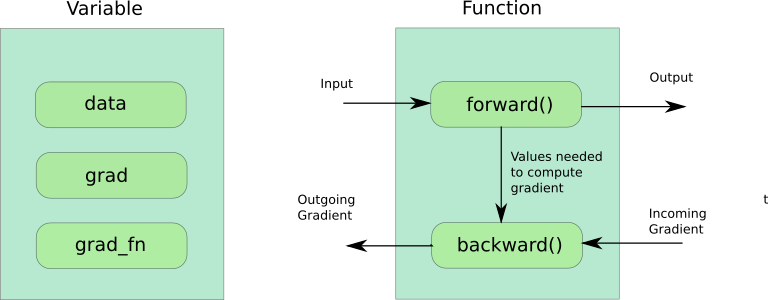

In [ ]:
# Lets create tensors with "requires_grad=True", which means that we want to calculate gradietnts for this tensor
w = torch.rand(1, requires_grad=True)
b = torch.rand(1, requires_grad=True)

x = torch.tensor(boston.data[:, -1] / boston.data[:, -1].max(), dtype=torch.float32)
y = torch.tensor(boston.target, dtype=torch.float32)

assert w.grad is None
assert b.grad is None

In [ ]:
y_pred = w * x + b                    # make some operations
loss = torch.mean((y_pred - y) ** 2)  # make some operations
loss.backward()                       # calculate gradients with ".backward()"

# No we can see gradients
assert w.grad is not None
assert b.grad is not None

print("dL/dw = \n", w.grad)
print("dL/db = \n", b.grad)

In [ ]:
from IPython.display import clear_output

for i in range(300):
    y_pred = w * x + b

    loss = torch.mean((y_pred - y)**2)
    loss.backward()

    # make a step
    w.data -=  0.05 * w.grad
    b.data -=  0.05 * b.grad

    # zero gradients
    w.grad.data.zero_()
    b.grad.data.zero_()

    # рисуем картинки
    if (i + 1) % 5 == 0:
        clear_output(True)
        plt.figure(figsize=(10,8))
        plt.scatter(x.data.numpy(), y.data.numpy(), label="data")
        plt.scatter(x.data.numpy(), y_pred.data.numpy(),
                    color="orange", linewidth=5, label="predictions")
        plt.xlabel("LSTAT", fontsize=14)
        plt.ylabel("MEDV (target)", fontsize=14)
        plt.title("Boston modelling", fontsize=18)
        plt.legend(fontsize=14)
        plt.show()

        print("loss = ", loss.data.numpy())
        if loss.data.numpy() < 0.1:
            print("Done!")
            break


### 4. Some details about learning pipeline

Before build your neural network, you need to think about how to train it. Firstly, you need to implement batching of your dataset

In order in this framework to be able to iterate over the data you need to create your own class inherited from `torch.utils.data.Dataset`.


You **need to implement** who methods: 

* `__len__` -- returns information about how many objects we have in the dataset
* `__getitem__` -- returns the sample and the target to it


Now let's write one ourselves, generate random data as a dataset.

In [ ]:
class RandomDataset(torch.utils.data.Dataset):
    """
    Our random dataset
    """
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return {"sample": torch.tensor(x[idx, :], dtype=torch.float), "target": y[idx]}

In [ ]:
x = np.random.rand(1000, 5)
y = np.random.rand(1000)

In [ ]:
our_dataset = RandomDataset(x, y)

In [ ]:
our_dataset.__getitem__(1)

In order to get batches from the data, pytorch uses such an entity as a dataloader, which accepts a class inherited from `torch.utils.data.Dataset` as input. Let's look at an example now:

In [ ]:
dataloader = torch.utils.data.DataLoader(our_dataset, batch_size=4)

In [ ]:
batch = next(iter(dataloader))

print(f"Sample:\n{batch['sample']}")
print(f"Target:\n{batch['target']}")

### 5. Build and apply simple fully connected nural network

#### How to make a neural network


In order to create neural networks in high-level pytorch, the `nn` module is used. The neural network must be inherited from the `nn.Module` class. An example of how it might look

```
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5)
        self.conv2 = nn.Conv2d(20, 20, 5)

    def forward(self, x):
       x = F.relu(self.conv1(x))
       return F.relu(self.conv2(x))
```

As we can see in this example, this class **must have a** method `forward`, which defines the direct passage of the neural network. Also from the class above you can see that the `nn` module contains the implementation of most of the layers, and the` nn.functional` module contains activation functions.

There is one more way to create a neural network and let's analyze it in practice:

In [ ]:
from torch import nn

model = nn.Sequential()                   # create an empty model to which we will add layers
model.add_module("l1", nn.Linear(5, 10))  # added a layer with 5 neurons at the input and 3 at the output
model.add_module("l2", nn.ReLU())         # added activation function
model.add_module("l3", nn.Linear(10, 1))  # added a layer with 3 neurons at the input and 5 at the output

# other way to do the same
another_model = nn.Sequential(
    nn.Linear(5, 10),
    nn.ReLU(),
    nn.Linear(10, 1)
)

In [ ]:
y_pred = model(batch['sample']) # making predictions

#### How to write a training loop and track metrics
 
Let's now collect data loading, create a model and train on the MNIST dataset that has already been created for us

In [ ]:
import torchvision

# we use a ready-made class from torch to load data for training
mnist_train = torchvision.datasets.MNIST(
    "./mnist/", 
    train=True, 
    download=True, 
    transform=torchvision.transforms.ToTensor()
) 
mnist_val = torchvision.datasets.MNIST(
    "./mnist/",
    train=False, 
    download=True,
    transform=torchvision.transforms.ToTensor()
)

# since this is already a class inherited from Tdataset, it can be immediately wrapped in a dataloader
train_dataloader = torch.utils.data.DataLoader(
    mnist_train, 
    batch_size=4, 
    shuffle=True, 
    num_workers=1
) 

val_dataloader = torch.utils.data.DataLoader(
    mnist_val, 
    batch_size=4, 
    shuffle=True, 
    num_workers=1
)

In [ ]:
# let's look at what we are working with
for i in [0, 1]:
    plt.subplot(1, 2, i + 1)
    plt.imshow(mnist_train[i][0].squeeze(0).numpy().reshape([28, 28]))
    plt.title(str(mnist_train[i][1]))
plt.show()

In [ ]:
model = nn.Sequential(
    nn.Flatten(),             # turning a 28x28 image into a 784 vector
    nn.Linear(28 * 28, 128),  # a linear layer that converts a vector of size 784 to a vector of size 128
    nn.ReLU(),                # non-linearity
    nn.Linear(128, 10),       # a linear layer that converts a vector of size 128 to a vector of size 10
)

# creating an optimizer that will update the weights of the model
optimizer = torch.optim.SGD(model.parameters(), lr=0.05) 

The weights of the models are stored as matrices and look like this:

In [ ]:
[x for x in model.named_parameters()] 

In [ ]:
from tqdm.notebook import tqdm

# in total we will have 5 epochs (5 times in a row we will go through all the matches from the train)
for epoch in range(1):
    for x_train, y_train in tqdm(train_dataloader):    # we take the batch from the train loader
        y_pred = model(x_train)                        # making predictions
        loss = F.cross_entropy(y_pred, y_train)        # calculate loss
        loss.backward()                                # calculate gradients
        optimizer.step()                               # updete parametrs
        optimizer.zero_grad()                          # drop gradients
    
    if epoch % 2 == 0:
        val_loss = []                                  # loss storing list
        val_accuracy = []
        with torch.no_grad():                          # no need grads when testing
            for x_val, y_val in tqdm(val_dataloader):  # we take the batch from the val loader
                y_pred = model(x_val)                  # making predictions
                loss = F.cross_entropy(y_pred, y_val)  # calculate loss
                val_loss.append(loss.numpy())          # store
                val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())
        
        # print metrics
        print(f"Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}")

### 5. Introduction to conv nets [mini-presentation (continued)](https://docs.google.com/presentation/d/1cc9n11O6I_18bunhgw8qfuJ7kp2ITD9hfIZsp_8lpJA/edit?usp=sharing)

### 6. Build and apply simple convolutional nural network

In [ ]:
def train_and_test_model(model, optimizer, train_dataloader, val_dataloader, epoches=5):
    # just copy and past code above
    for epoch in range(epoches):
        for x_train, y_train in tqdm(train_dataloader):    # we take the batch from the train loader
            y_pred = model(x_train)                        # making predictions
            loss = F.cross_entropy(y_pred, y_train)        # calculate loss
            loss.backward()                                # calculate gradients
            optimizer.step()                               # updete parametrs
            optimizer.zero_grad()                          # drop gradients

        if epoch % 2 == 0:
            val_loss = []                                  # loss storing list
            val_accuracy = []
            with torch.no_grad():                          # no need grads when testing
                for x_val, y_val in tqdm(val_dataloader):  # we take the batch from the val loader
                    y_pred = model(x_val)                  # making predictions
                    loss = F.cross_entropy(y_pred, y_val)  # calculate loss
                    val_loss.append(loss.numpy())          # store
                    val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())

            # print metrics
            print(f"Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}")
    

In [ ]:
import torchvision

# we use a ready-made class from torch to load data for training
cifar_train = torchvision.datasets.CIFAR10(
    "./mnist/", 
    train=True, 
    download=True, 
    transform=torchvision.transforms.ToTensor()
) 
cifar_val = torchvision.datasets.CIFAR10(
    "./mnist/",
    train=False, 
    download=True,
    transform=torchvision.transforms.ToTensor()
)

# since this is already a class inherited from Tdataset, it can be immediately wrapped in a dataloader
train_dataloader = torch.utils.data.DataLoader(
    cifar_train, 
    batch_size=4, 
    shuffle=True, 
    num_workers=1
) 

val_dataloader = torch.utils.data.DataLoader(
    cifar_val, 
    batch_size=4, 
    shuffle=True, 
    num_workers=1
)

In [ ]:
# let's look at what we are working with
plt.figure(figsize=(14, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(np.transpose(cifar_train[i][0].numpy(), [1,2,0]))
    plt.title(cifar_train.classes[cifar_train[i][1]])
plt.show()

In [ ]:
model = nn.Sequential(
    nn.Flatten(),                 # turning a 3x32x32 image into a 3072 vector
    nn.Linear(3 * 32 * 32, 128),  # a linear layer that converts a vector of size 3072 to a vector of size 128
    nn.ReLU(),                    # non-linearity
    nn.Linear(128, 10),           # a linear layer that converts a vector of size 128 to a vector of size 10
)

# creating an optimizer that will update the weights of the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 

train_and_test_model(model, optimizer, train_dataloader, val_dataloader)

# Epoch: 4, loss: 1.8430081605911255, accuracy: 0.3336

In [ ]:
model = nn.Sequential(  
    # input [4, 3, 32, 32]
    nn.Conv2d(3, 128, 3),    # apply convolution with 128 kernels size of 3. [4, 128, 30, 30]
    nn.ReLU(),               # non-linearity [4, 128, 30, 30]
    nn.MaxPool2d(3),         # apply max pooling to image size reduction [4, 128, 10, 10]

                             # doing exactly the same.
    nn.Conv2d(128, 128, 3),  # [4, 128, 8, 8]
    nn.ReLU(),               # [4, 128, 8, 8]
    nn.MaxPool2d(3),         # [4, 128, 2, 2]

    nn.Flatten(),             # converting into a 512 vector. [4, 512]
    nn.Linear(512, 10),       # a linear layer that converts a vector of size 512 to a vector of size 10. [4, 10]
)

# creating an optimizer that will update the weights of the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 

train_and_test_model(model, optimizer, train_dataloader, val_dataloader)

# Epoch: 4, loss: 1.135080099105835, accuracy: 0.6027
# But if you will use some extra layers and train longe you can get > 80% accuracy easily

In [ ]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(n_estimators=1000, verbose=True, task_type="GPU")
model.fit(cifar_train.data.reshape((-1, 3*32*32)), cifar_train.targets)
test_pred = model.predict_proba(cifar_val.data.reshape((-1, 3*32*32))).argmax(-1)
print(f"accuracy: {np.mean(test_pred == np.array(cifar_val.targets))}")

# accuracy: 0.5784